Results
---

08.04.2022  
* Dataset: "complete" (50 features):  
    * 23 items of FFMQ  
    * 20 items of UPPS-P  
    * 5 items of DMQ-coping  
    * 1 item for weekly working hours  
    * 1 item for sex 
    
* Tested regressors:
    * ElasticNet (scikit-learn)  
    * ExtraTreesRegressor (scikit-learn)  
    * LGBMRegressor (lightgbm)
    
* Cross validation:
    * 50 shuffle splits outer loop
    * 50 shuffle splits inner loop with bayesian hyperparameter optimization

## model scores

In [14]:
import pandas as pd

#results_path = "./results/2022-03-31_10-06-05/"
#results_path = "./results/2022-04-05_12-15-16/"
results_path = "./results/2022-04-08_11-12-00/"

results = pd.read_csv(results_path + "report.csv", sep=";", encoding="latin1",index_col=["Type","Split"]).sort_index()
results_grp = results.groupby("Type").mean()[["Train score (R²)","Test score (R²)"]].sort_values("Test score (R²)",ascending=False)

hline =  "\n--------------------------------------------\n"
hdline = "\n============================================\n"

print("R²")

for reg in results.index.levels[0]:
    print(hdline,"# "+reg + "  => mean ",format(results_grp.loc[reg][1],".3f"),"(train: " + format(results_grp.loc[reg][0],".3f")+")"+hdline)
    for split in results.index.levels[1]:
        ...
        # uncomment for printing details
        #print(hline,"## Split",str(split) + "  => ",format(results.loc[(reg,split)][2],".3f"),"(train: ",format(results.loc[(reg,split)][1],".3f")+")",hline)
        #print(results.loc[(reg,split),"Model"].replace("(","").replace(")","").replace(reg,"").replace(" ","").replace(",","\n").replace("\n\n","\n"))

R²

 # ElasticNet  => mean  0.332 (train: 0.418)


 # ExtraTreesRegressor  => mean  0.307 (train: 0.820)


 # LGBMRegressor  => mean  0.230 (train: 0.425)



## feature importance

In [15]:
import os
import json
import numpy as np
from get_data import get_mindfulness as get_data

json_files = [file for file in os.listdir(results_path) if file.lower()[-5:]==".json"]
X,_ = get_data("complete")
features = list(X.columns)
fi_types = ["m_imp","s_imp"]

# create empty dictionary tree
feature_importance = dict()
for reg in results.index.levels[0]:
    feature_importance[reg] = dict()
    for split in results.index.levels[1]:
        feature_importance[reg][split] = dict()
        for x_imp in fi_types:
            feature_importance[reg][split][x_imp] = dict()
            
# fill dictionary
for json_f in json_files:
    with open(results_path + json_f, "r") as fo:
        feat_data = np.array(json.load(fo)).T
    reg = json_f[:json_f.find("_")]
    split = int(json_f[1 + json_f.find("_"):json_f.find("_",1 + json_f.find("_"))])
    x_imp = json_f[-10:-5]
    feat_dict = dict(list(zip(features,feat_data)))
    feature_importance[reg][split][x_imp] = feat_dict

### Model importance

In [16]:
import matplotlib.pyplot as plt


def plot_m_imp(reg,feature_importance):
    # sum
    for i,split in enumerate(feature_importance[reg]):
        if i > 0:
            df = df + pd.DataFrame(
                feature_importance[reg][split]["m_imp"]\
                .items(),columns=["feature","importance"])\
                .set_index("feature")
        else: # for the first iteration
            df = pd.DataFrame(
                feature_importance[reg][split]["m_imp"]\
                .items(),columns=["feature","importance"])\
                .set_index("feature")

    # divide by number of splits -> mean
    df = df/len(feature_importance[reg])
    df = df.sort_values("importance",ascending=False)

    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_title("Feature importance\n" + reg)
    ax.plot(df,marker="o")
    ax.grid(linewidth=0.25)
    ax.set_xticks(range(len(df)),labels=df.index,rotation=90);

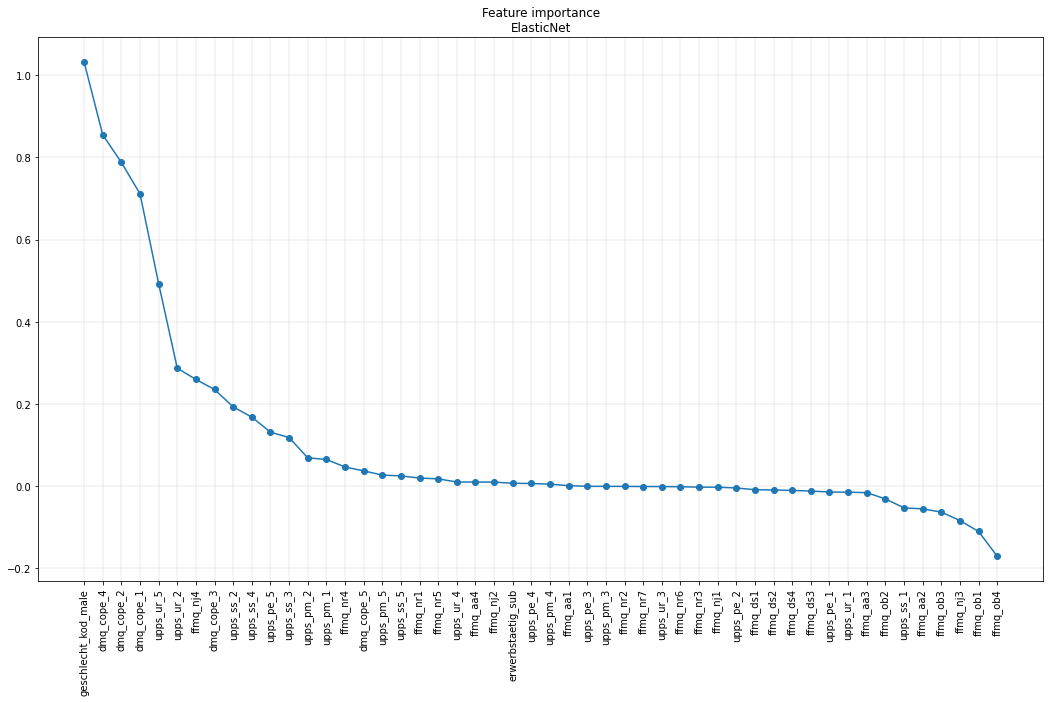

In [17]:
plot_m_imp("ElasticNet",feature_importance)

In [18]:
#plot_m_imp("RandomForestRegressor",feature_importance)

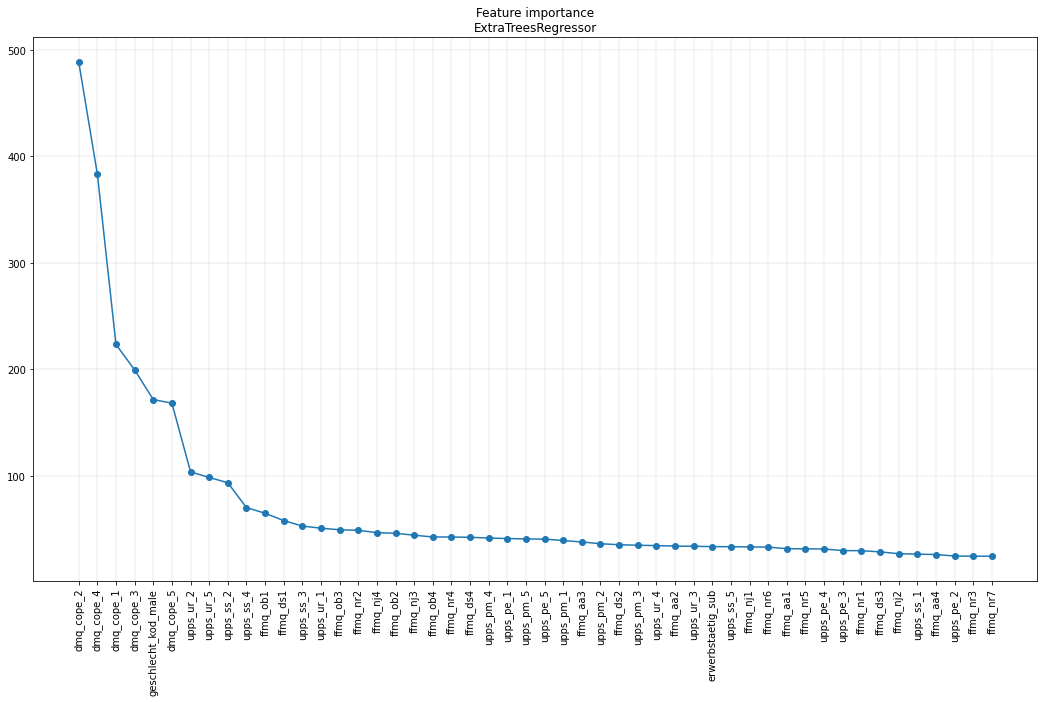

In [19]:
plot_m_imp("ExtraTreesRegressor",feature_importance)

In [20]:
#plot_m_imp("GradientBoostingRegressor",feature_importance)

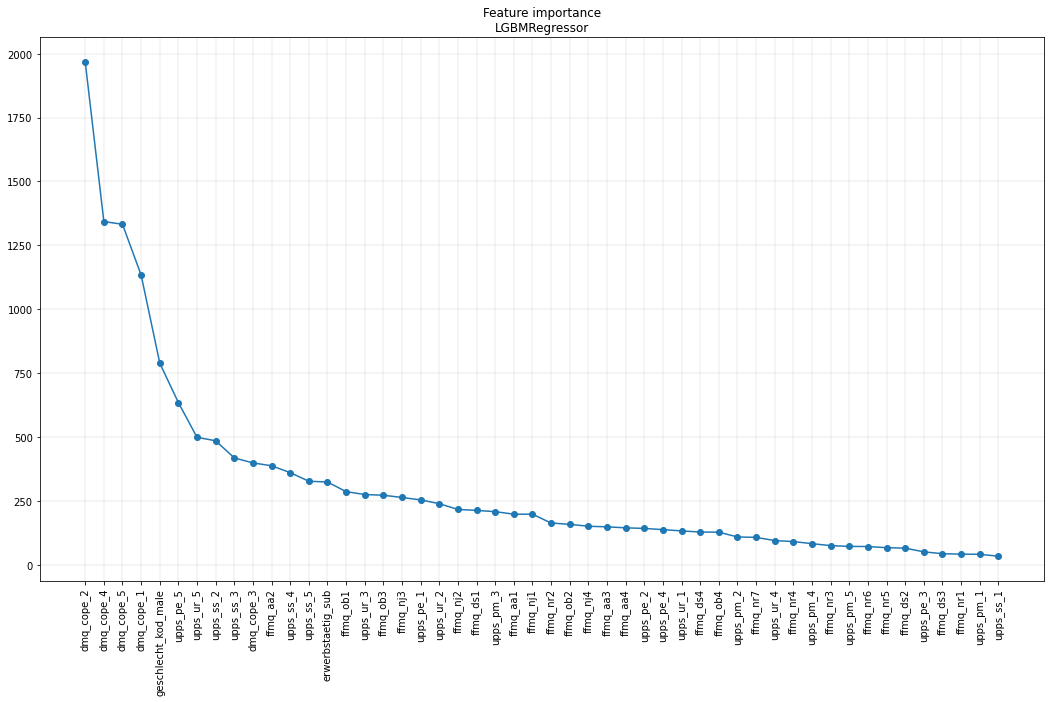

In [21]:
plot_m_imp("LGBMRegressor",feature_importance)

### SHAP importance 

**Average shap values across all splits**

In [22]:
from get_data import get_mindfulness as get_data
from utils import split_train_test
import numpy as np

X,y = get_data("complete")

# this should be taken from the original train/test splits
i_train = range(0,399)
i_test = range(399,498)

X_train, X_test = split_train_test(X, i_train, i_test)
y_train, y_test = split_train_test(y, i_train, i_test)

In [23]:
import shap
from glob import glob

feature_names = [key for key in feature_importance[list(feature_importance.keys())[0]][1]["s_imp"].keys()]

def get_avg_shap_values(reg):
    s_imp_files = glob(results_path + reg + "_" + "*" + "_s_imp.json")
    splits = len(s_imp_files)

    shap_values = np.array([])

    for s_imp_file in s_imp_files:
        with open(s_imp_file, "r") as fo:
            shap_values_new = np.array(json.load(fo))
            if len(shap_values) == 0:
                shap_values = shap_values_new
            else:
                # average step 1/2: sum
                shap_values += shap_values_new

    # average step 2/2: divide by n splits             
    shap_values /= splits
    
    return shap_values 

def plot_hist(shap_values,nrows=9,ncols=6):

    plt.subplots(nrows,ncols,figsize=(18,24),sharex=True,sharey=True)

    for i in range(len(shap_values.T)):

        plt.subplot(nrows,ncols,i + 1)
        plt.hist(shap_values.T[i], bins=5)
        plt.title(feature_names[i])
        
def summary_top_features(shap_values,feature_names,top_x=10):
    shap_sum = np.abs(shap_values).mean(axis=0)

    importance_df = pd.DataFrame([feature_names, shap_sum.tolist()]).T

    importance_df.columns = ['feature', 'shap_importance']
    importance_df = importance_df.sort_values('shap_importance', ascending=False).head(top_x).reset_index(drop=True)
    importance_df.index += 1
    print(importance_df,"\n")

### ElasticNet: Shap values summary across all splits


 ElasticNet 

                feature shap_importance
1            dmq_cope_2          0.1093
2            dmq_cope_4        0.086107
3            dmq_cope_1        0.073999
4   geschlecht_kod_male        0.062747
5             upps_ur_5        0.045298
6              ffmq_nj4        0.032517
7            dmq_cope_3        0.028639
8             upps_ss_2        0.025983
9             upps_ss_4        0.023484
10            upps_ur_2         0.02228 



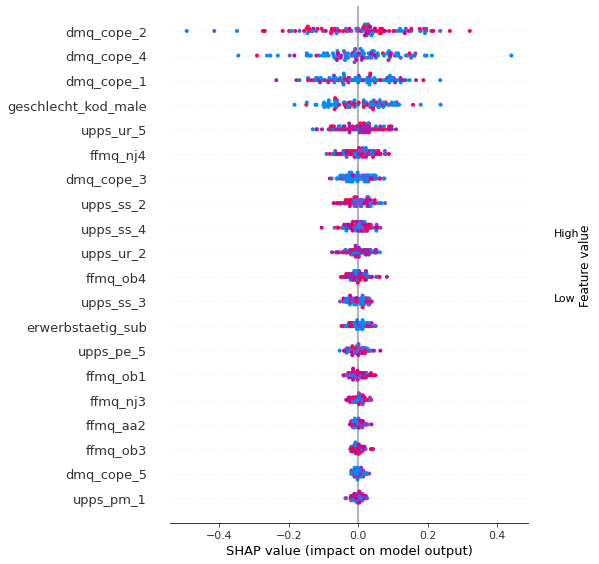

In [34]:
reg = "ElasticNet"

print("\n",reg,"\n")
shap_values_avg = get_avg_shap_values(reg)
summary_top_features(shap_values_avg,feature_names)
shap.summary_plot(shap_values_avg,features=X_test, feature_names=feature_names, title=reg)
#plot_hist(shap_values)

### ElasticNet: Shap values visualized with waterfall plot per case and per split

Example: Split 1, Case 1

In [46]:
print(results.iloc[0,0])

ElasticNet(alpha=0.2475765283005601, l1_ratio=0.7364676814799669)


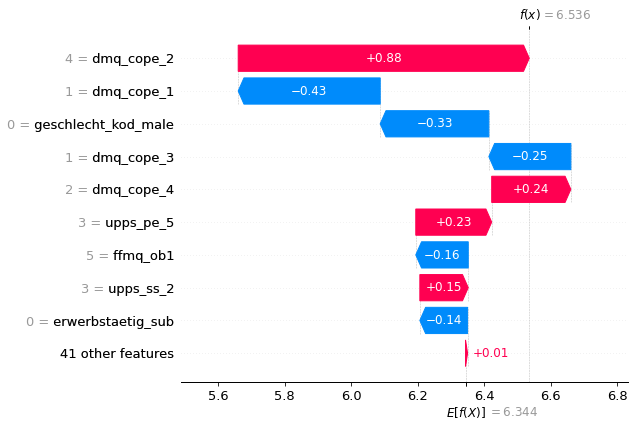

In [33]:
from sklearn.linear_model import ElasticNet


model = ElasticNet(alpha=0.2475765283005601, l1_ratio=0.7364676814799669)
model.fit(X_train,y_train)

explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])

### LGBMRegressor: Shap values summary across all splits


 LGBMRegressor 

                feature shap_importance
1            dmq_cope_2        0.064135
2            dmq_cope_4        0.050476
3            dmq_cope_5        0.043468
4            dmq_cope_1        0.041872
5             upps_pe_5        0.039741
6   geschlecht_kod_male        0.038748
7              ffmq_ob1        0.029894
8             upps_ur_5        0.028541
9             upps_ss_2        0.026347
10             ffmq_aa2        0.026183 



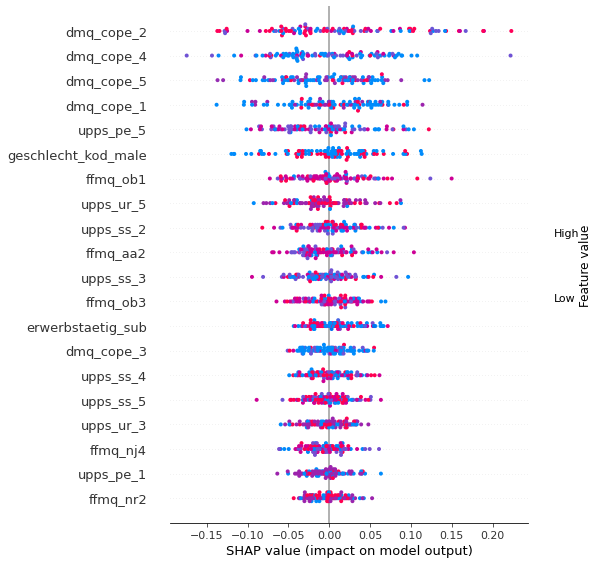

In [35]:
reg = "LGBMRegressor"

print("\n",reg,"\n")
shap_values_avg = get_avg_shap_values(reg)
summary_top_features(shap_values_avg,feature_names)
shap.summary_plot(shap_values_avg,features=X_test, feature_names=feature_names, title=reg)
#plot_hist(shap_values)

### LGBMRegressor: Shap values visualized with waterfall plot per case and per split

Example: Split 1, Case 1

In [45]:
print(results.iloc[100,0])

LGBMRegressor(colsample_bytree=0.01, importance_type='gain',
              learning_rate=0.10902360191916745, min_child_samples=1,
              min_child_weight=0.0001, n_estimators=256, n_jobs=1,
              num_leaves=256)


Permutation explainer: 100it [00:34,  2.04it/s]                                                                        


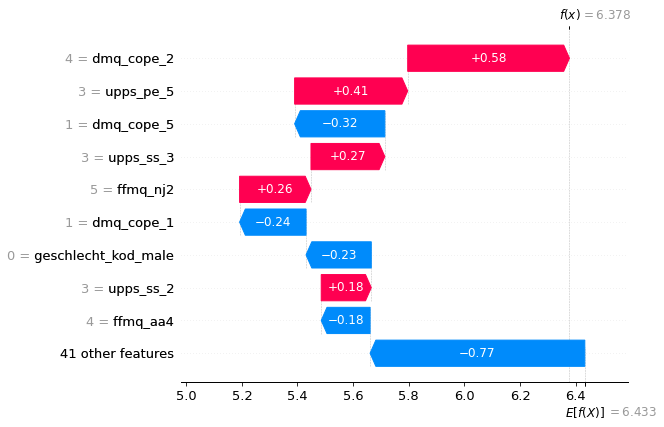

In [48]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(colsample_bytree=0.01, importance_type='gain',
              learning_rate=0.10902360191916745, min_child_samples=1,
              min_child_weight=0.0001, n_estimators=256, n_jobs=1,
              num_leaves=256)
model.fit(X_train,y_train)

explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])

### ExtraTreesRegressor: Shap values summary across all splits


 ExtraTreesRegressor 

                feature shap_importance
1            dmq_cope_2         0.10431
2            dmq_cope_4        0.078639
3   geschlecht_kod_male         0.06363
4            dmq_cope_1        0.045974
5            dmq_cope_3        0.041042
6            dmq_cope_5        0.031037
7             upps_ss_2        0.029175
8             upps_ur_2        0.022826
9             upps_ss_4        0.021705
10            upps_ur_5         0.02149 



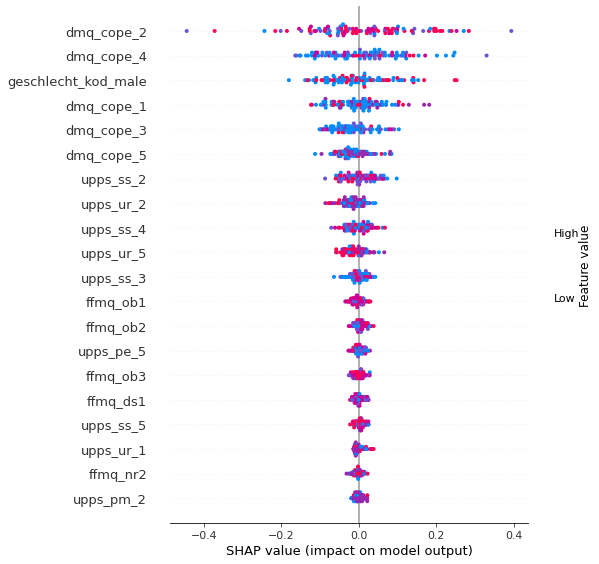

In [52]:
reg = "ExtraTreesRegressor"

print("\n",reg,"\n")
shap_values_avg = get_avg_shap_values(reg)
summary_top_features(shap_values_avg,feature_names)
shap.summary_plot(shap_values_avg,features=X_test, feature_names=feature_names, title=reg)
#plot_hist(shap_values)

### ExtraTreesRegressor: Shap values visualized with waterfall plot per case and per split

Example: Split 1, Case 1

In [50]:
print(results.iloc[50,0])

ExtraTreesRegressor(max_features=0.2843695723799096, min_samples_split=5,
                    n_estimators=256, random_state=0)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
Permutation explainer: 100it [00:52,  1.52it/s]                                                                        


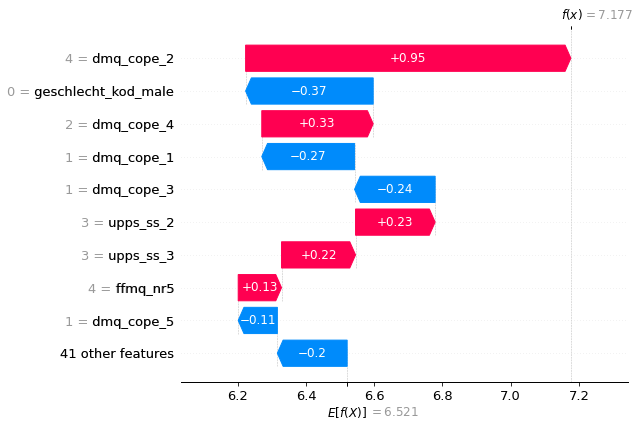

In [51]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor(max_features=0.2843695723799096, min_samples_split=5,
                    n_estimators=256, random_state=0)
model.fit(X_train,y_train)

explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])